### Pair Z-Score Strategy vs Baseline on data_cleaned.parquet
#### - Handles missing timestamps (irregular sampling)
#### - Computes P/L using: dPnL_t = position_{t-1} * (Spread_t - Spread_{t-1}) * (TTE_t)^0.7
#### - Baseline strategy: sign(spread)
#### - Z-score strategy: enter on |z| >= 1.0, exit on |z| <= 0.25 (with persistence/hysteresis)
#### - Uses time-based rolling windows to be robust to gaps
#### - Outputs result CSVs and plots to /mnt/data/results_iv_pairs/

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Tuple, Dict

In [2]:
RESULT_DIR = "results/results_iv_pairs"
os.makedirs(RESULT_DIR, exist_ok=True)

In [3]:
# ---------- Load data ----------
# Try a few likely paths; if not found, create a small demo dataset to illustrate the pipeline.
possible_paths = [
    "data_cleaned.parquet",
    "/mnt/data/data_cleaned.parquet",
    "data/data_cleaned.parquet",
]

df = None
for p in possible_paths:
    if os.path.exists(p):
        df = pd.read_parquet(p)
        break

if df is None:
    # Create a demo dataset (1 trading day, 09:15–15:30 IST) with small random gaps
    rng = pd.date_range("2021-01-01 09:15", "2021-01-01 15:30", freq="1min")
    rng = rng.delete(np.random.choice(len(rng), size=60, replace=False))  # random gaps
    np.random.seed(42)
    base_iv_nifty = 0.20 + 0.005*np.sin(np.linspace(0, 10, len(rng)))
    base_iv_banknifty = 0.28 + 0.007*np.cos(np.linspace(0, 10, len(rng)))
    noise_n = np.random.normal(0, 0.0008, len(rng))
    noise_b = np.random.normal(0, 0.0010, len(rng))
    df = pd.DataFrame({
        "nifty": base_iv_nifty + noise_n,
        "banknifty": base_iv_banknifty + noise_b,
        "tte": np.full(len(rng), 27, dtype=float),
    }, index=rng)
    df.index.name = "time"

# Ensure datetime index named 'time'
if not isinstance(df.index, pd.DatetimeIndex):
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    else:
        # Try to infer first column as time
        df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Minimal column checks
required = {"nifty", "banknifty", "tte"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found columns: {df.columns.tolist()}")


In [4]:
# ---------- Core calculations ----------
# Spread and TTE scaling
df["spread"] = df["banknifty"] - df["nifty"]
df["tte_pow"] = np.power(df["tte"].astype(float), 0.7)

# Minute-to-minute change in spread (robust to irregular stamps; we do not resample)
df["dspread"] = df["spread"].diff()

In [5]:
# ---------- Baseline strategy ----------
# Rule: position = sign(spread). Persistent (±1 or 0 if spread == 0)
# Uses previous position for PnL to avoid look-ahead
def baseline_position(s: pd.Series) -> pd.Series:
    pos = s.apply(lambda x: 0.0 if pd.isna(x) or x == 0 else (1.0 if x > 0 else -1.0))
    return pos

df["pos_baseline"] = baseline_position(df["spread"])

# PnL per bar
df["pnl_baseline"] = df["pos_baseline"].shift(1) * df["dspread"] * df["tte_pow"]

In [6]:
# ---------- Z-score strategy with 0 latency ----------
# Time-based rolling window to handle gaps
ROLL_WINDOW = "90min"
MIN_PERIODS = 30  # need at least 30 points in the rolling window

roll_mean = df["spread"].rolling(ROLL_WINDOW, min_periods=MIN_PERIODS).mean()
roll_std = df["spread"].rolling(ROLL_WINDOW, min_periods=MIN_PERIODS).std(ddof=0)
df["z"] = (df["spread"] - roll_mean) / roll_std

Z_ENTER = 1.0
Z_EXIT = 0.25

In [7]:
def zscore_positions(z: pd.Series, enter: float, exit_: float) -> pd.Series:
    """
    Persistent positions with hysteresis:
      - If z >= enter -> short spread (-1)
      - If z <= -enter -> long spread (+1)
      - Exit to 0 when |z| <= exit_
      - Otherwise keep previous position
    """
    pos = np.zeros(len(z), dtype=float)
    prev = 0.0
    for i, val in enumerate(z.values):
        if pd.isna(val):
            pos[i] = prev
            continue
        if val >= enter:
            prev = -1.0
        elif val <= -enter:
            prev = +1.0
        elif abs(val) <= exit_:
            prev = 0.0
        # else keep prev
        pos[i] = prev
    return pd.Series(pos, index=z.index)

df["pos_z"] = zscore_positions(df["z"], Z_ENTER, Z_EXIT)
df["pnl_z"] = df["pos_z"].shift(1) * df["dspread"] * df["tte_pow"]

In [8]:
# ---------- Metrics ----------
def equity_and_dd(pnl: pd.Series) -> Tuple[pd.Series, float]:
    eq = pnl.fillna(0).cumsum()
    peak = eq.cummax()
    dd = (eq - peak)
    max_dd = dd.min()  # most negative
    return eq, float(max_dd)

def sharpe_from_daily(pnl: pd.Series) -> float:
    # Aggregate minute PnL to daily PnL, then annualize with sqrt(252)
    if pnl.dropna().empty:
        return float("nan")
    daily = pnl.fillna(0).groupby(pnl.index.date).sum()
    mu = daily.mean()
    sd = daily.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return float("nan")
    return float(mu / sd * math.sqrt(252.0))

def summarize_strategy(pnl: pd.Series, label: str) -> Dict[str, float]:
    eq, max_dd = equity_and_dd(pnl)
    total_pl = float(pnl.fillna(0).sum())
    abs_pl = float(pnl.fillna(0).abs().sum())
    sharpe = sharpe_from_daily(pnl)
    trades = int((pnl.fillna(0) != 0).astype(int).diff().abs().clip(upper=1).sum() // 2)
    return {
        "strategy": label,
        "total_PnL": total_pl,
        "abs_PnL": abs_pl,
        "sharpe_annualized": sharpe,
        "max_drawdown": max_dd,
        "num_points": int(pnl.shape[0]),
        "approx_trades": trades,
    }

metrics = pd.DataFrame([
    summarize_strategy(df["pnl_baseline"], "baseline_sign_spread"),
    summarize_strategy(df["pnl_z"], "zscore_90min_ent1_exit0.25"),
])

In [9]:
# ---------- Save outputs ----------
# Metrics and time series
metrics_path = os.path.join(RESULT_DIR, "metrics.csv")
df_out = df[["nifty", "banknifty", "tte", "spread", "z", "pos_baseline", "pnl_baseline", "pos_z", "pnl_z"]].copy()
ts_path = os.path.join(RESULT_DIR, "timeseries_with_signals.csv")

metrics.to_csv(metrics_path, index=False)
df_out.to_csv(ts_path)

In [10]:
# Equity curves
eq_base, _ = equity_and_dd(df["pnl_baseline"])
eq_z, _ = equity_and_dd(df["pnl_z"])
eq_df = pd.DataFrame({"equity_baseline": eq_base, "equity_zscore": eq_z})
eq_path = os.path.join(RESULT_DIR, "equity_curves.csv")
eq_df.to_csv(eq_path)

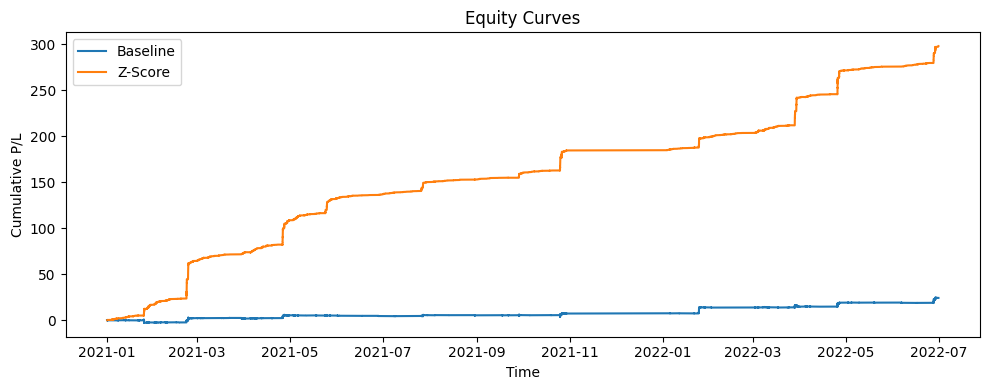

In [11]:
# ---------- Plots ----------
# 1) Equity curve comparison
plt.figure(figsize=(10, 4))
plt.plot(eq_df.index, eq_df["equity_baseline"], label="Baseline")
plt.plot(eq_df.index, eq_df["equity_zscore"], label="Z-Score")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Cumulative P/L")
plt.title("Equity Curves")
plt.tight_layout()
plot1_path = os.path.join(RESULT_DIR, "equity_curves.png")
plt.savefig(plot1_path, dpi=150)
plt.show()

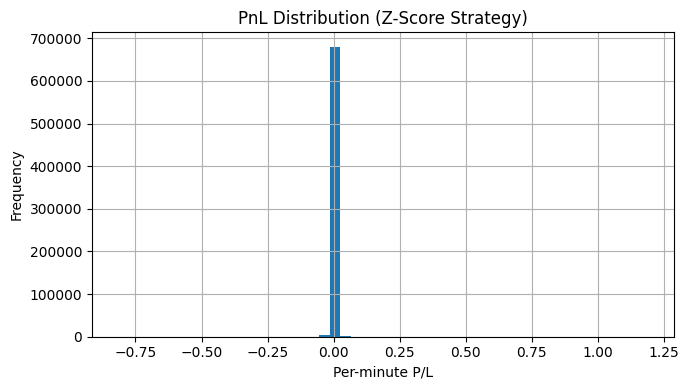

In [12]:
# 3) Histogram of per-minute PnL (z-score strategy)
plt.figure(figsize=(7, 4))
df["pnl_z"].dropna().hist(bins=50)
plt.xlabel("Per-minute P/L")
plt.ylabel("Frequency")
plt.title("PnL Distribution (Z-Score Strategy)")
plt.tight_layout()
plot4_path = os.path.join(RESULT_DIR, "pnl_hist_z.png")
plt.savefig(plot4_path, dpi=150)
plt.show()

In [13]:
# ---------- Z-score strategy with 1 latency ----------
# --- Add 1-minute latency ---
df["pos_z_latency"] = df["pos_z"].shift(1)
df["pnl_z_latency"] = df["pos_z_latency"].shift(1) * df["dspread"] * df["tte_pow"]

# --- Summarize strategies ---
metrics = pd.DataFrame([
    summarize_strategy(df["pnl_baseline"], "Baseline (sign spread)"),
    summarize_strategy(df["pnl_z_latency"], "Z-Score + 1m latency")
])
display(metrics)

,strategy,total_PnL,abs_PnL,sharpe_annualized,max_drawdown,num_points,approx_trades
0,Baseline (sign spread),24.225911,1268.587827,1.734532,-3.757137,687013,310
1,Z-Score + 1m latency,114.757662,889.895484,5.074669,-2.854294,687013,5400


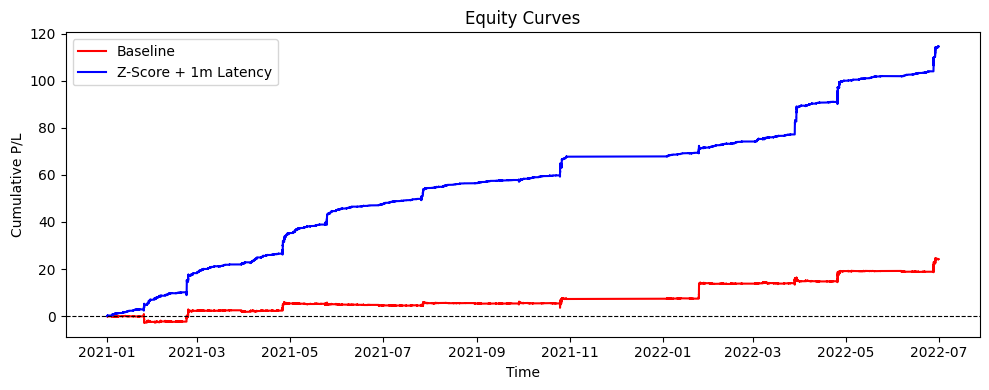

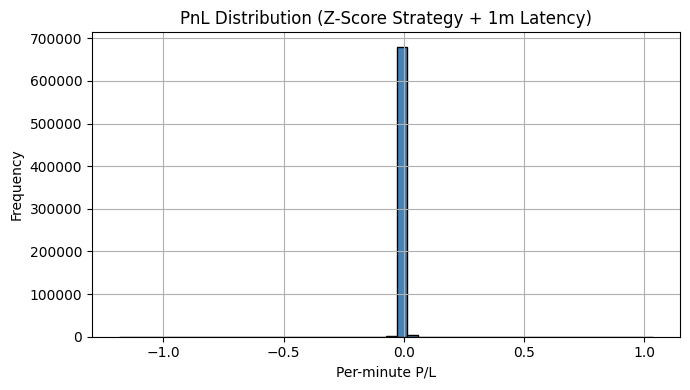

In [14]:

# --- Equity curves ---
eq_base, _ = equity_and_dd(df["pnl_baseline"])
eq_zlat, _ = equity_and_dd(df["pnl_z_latency"])
eq_df = pd.DataFrame({"Baseline": eq_base, "Z-Score+1m": eq_zlat})

plt.figure(figsize=(10, 4))
plt.plot(eq_df.index, eq_df["Baseline"], label="Baseline", color="red")
plt.plot(eq_df.index, eq_df["Z-Score+1m"], label="Z-Score + 1m Latency", color="blue")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xlabel("Time")
plt.ylabel("Cumulative P/L")
plt.title("Equity Curves")
plt.legend()
plt.tight_layout()
plt.show()

# --- Histogram of per-minute PnL (latency strategy) ---
plt.figure(figsize=(7, 4))
df["pnl_z_latency"].dropna().hist(bins=50, color="steelblue", edgecolor="black")
plt.xlabel("Per-minute P/L")
plt.ylabel("Frequency")
plt.title("PnL Distribution (Z-Score Strategy + 1m Latency)")
plt.tight_layout()
plt.show()

In [15]:
# ---------- Save outputs ----------
# Metrics and time series
RESULT_DIR = "results/results_iv_pairs_1m_latency"
os.makedirs(RESULT_DIR, exist_ok=True)
metrics_path = os.path.join(RESULT_DIR, "metrics.csv")
df_out = df[["nifty", "banknifty", "tte", "spread", "z", "pos_baseline", "pnl_baseline", "pos_z", "pnl_z"]].copy()
ts_path = os.path.join(RESULT_DIR, "timeseries_with_signals.csv")

metrics.to_csv(metrics_path, index=False)
df_out.to_csv(ts_path)